## Clasificador

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
folder_dogs = 'cats_and_dogs_small/dogs/' 
folder_cats = 'cats_and_dogs_small/cats/'

img_dogs_and_cats = []
labels_dogs_and_cats = []

In [3]:
for index, images_folder in enumerate([folder_dogs, folder_cats]):
    for image in os.listdir(images_folder):
        if image.endswith(('.jpg')):
            path = images_folder + image
            image = cv2.imread(path)
            if image is not None:
                image = cv2.resize(image, (200, 200))
                img_dogs_and_cats.append(image)
                labels_dogs_and_cats.append(index)
            else:
                print(path)

print(type(img_dogs_and_cats), type(labels_dogs_and_cats))
print(len(img_dogs_and_cats), len(labels_dogs_and_cats))


<class 'list'> <class 'list'>
3829 3829


In [4]:
img_dogs_and_cats[0].shape

(200, 200, 3)

In [5]:
img_dogs_and_cats = np.array(img_dogs_and_cats)
labels_dogs_and_cats = np.array(labels_dogs_and_cats)

print(type(img_dogs_and_cats), type(labels_dogs_and_cats))
print(img_dogs_and_cats.shape, labels_dogs_and_cats.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3829, 200, 200, 3) (3829,)


In [6]:
temp_index = np.arange(len(img_dogs_and_cats))
np.random.shuffle(temp_index)


img_dogs_and_cats = img_dogs_and_cats[temp_index]
labels_dogs_and_cats = labels_dogs_and_cats[temp_index]

print(img_dogs_and_cats.shape, labels_dogs_and_cats.shape)

(3829, 200, 200, 3) (3829,)


0


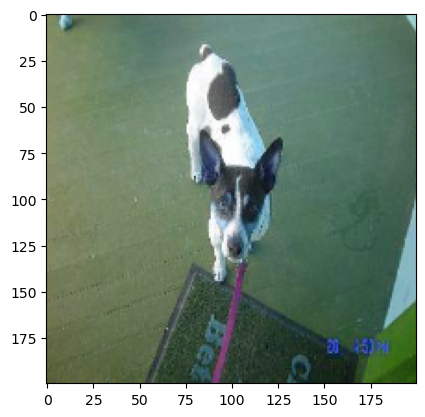

In [7]:
image = img_dogs_and_cats[20]
print(labels_dogs_and_cats[20])
plt.imshow(image)

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(img_dogs_and_cats, labels_dogs_and_cats, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.7, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(2680, 200, 200, 3) (2680,)
(805, 200, 200, 3) (805,)
(344, 200, 200, 3) (344,)


## Training

In [9]:
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
import tensorflow as tf

import keras
import visualkeras

In [10]:
mobileNet_model = keras.applications.MobileNet(weights='imagenet', include_top = False, input_shape=(200,200,3))

#Avoid retrain
for layer in mobileNet_model.layers:
  layer.trainable = False

mobileNet_model.summary()

2024-08-13 17:41:36.360861: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-13 17:41:36.360903: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-13 17:41:36.360915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-13 17:41:36.362388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-13 17:41:36.362938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 100, 100, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 100, 100, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 100, 100, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 100, 100, 32

In [11]:
#plot_model(resnet_model, to_file='images/resnet_model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

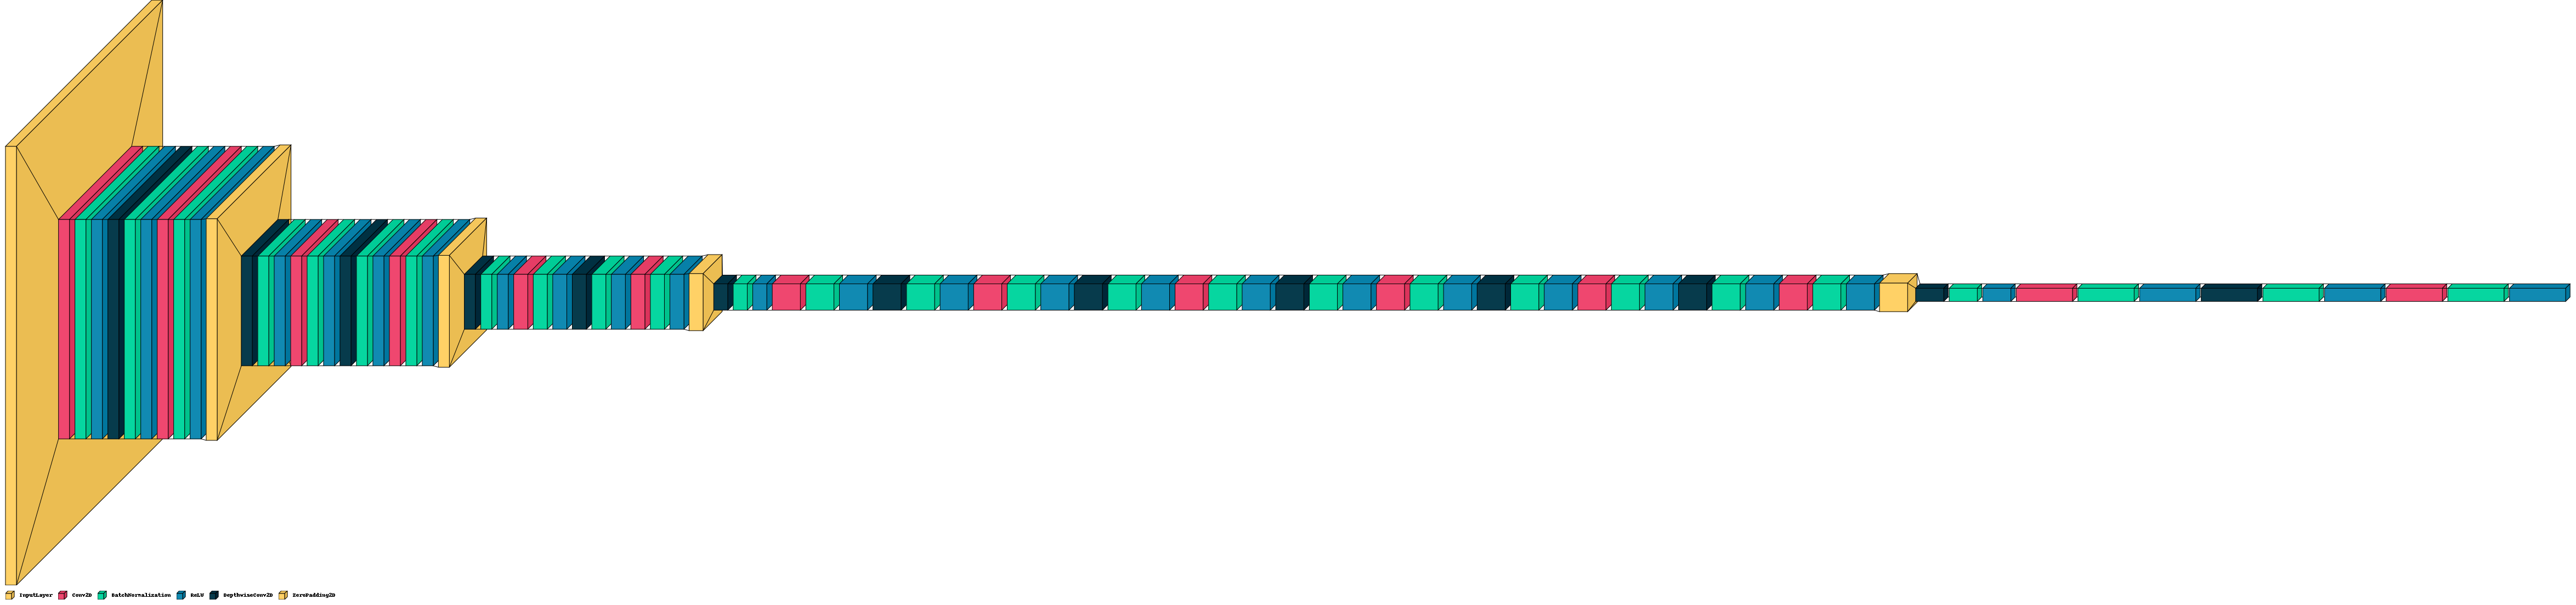

In [12]:
visualkeras.layered_view(mobileNet_model, legend=True)

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # Horizontal flip
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.17),  # Random rotation up to 30 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15),  # Random zoom up to 15%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=.2, width_factor=.2),  # Random shear up to 20%
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0, input_shape=(200, 200, 3))
])

In [14]:
new_model = Sequential()

new_model.add(data_augmentation)
new_model.add(mobileNet_model)

new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(240, activation = "sigmoid"))
new_model.add(Dense(120, activation = "sigmoid"))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation="sigmoid"))

#new_model.summary()
#new_model.build((None,200,200,3))

new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           metrics = ['accuracy'])


In [15]:
epochs = 20
history_model = new_model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=32, verbose=2)

Epoch 1/20


2024-08-13 17:41:40.492355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 17:41:41.068185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:41:46.942104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:41:47.201064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:41:47.323214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:41:47.428507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13

84/84 - 31s - loss: 0.3121 - accuracy: 0.8590 - val_loss: 0.0573 - val_accuracy: 0.9884 - 31s/epoch - 366ms/step
Epoch 2/20


2024-08-13 17:42:09.821054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:09.964915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:10.084545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:10.387790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:10.644260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:10.841553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 22s - loss: 0.1785 - accuracy: 0.9220 - val_loss: 0.0574 - val_accuracy: 0.9738 - 22s/epoch - 265ms/step
Epoch 3/20


2024-08-13 17:42:32.262640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:32.508712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:32.655332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:32.931423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:33.213938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:33.370851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 19s - loss: 0.1549 - accuracy: 0.9328 - val_loss: 0.0739 - val_accuracy: 0.9651 - 19s/epoch - 222ms/step
Epoch 4/20


2024-08-13 17:42:50.750878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:50.925109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:51.174955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:51.447795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:51.634902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:42:51.882893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 23s - loss: 0.1572 - accuracy: 0.9336 - val_loss: 0.1012 - val_accuracy: 0.9535 - 23s/epoch - 273ms/step
Epoch 5/20


2024-08-13 17:43:13.693271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:13.946935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:14.184789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:14.361299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:14.576388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:14.789933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 21s - loss: 0.1460 - accuracy: 0.9463 - val_loss: 0.0814 - val_accuracy: 0.9622 - 21s/epoch - 250ms/step
Epoch 6/20


2024-08-13 17:43:34.705753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:34.872964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:35.124952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:35.389394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:35.552277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:35.862219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 23s - loss: 0.1485 - accuracy: 0.9422 - val_loss: 0.1090 - val_accuracy: 0.9593 - 23s/epoch - 270ms/step
Epoch 7/20


2024-08-13 17:43:57.437101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:57.873066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:58.251216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:58.548180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:58.735009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:43:58.932273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 19s - loss: 0.1441 - accuracy: 0.9433 - val_loss: 0.0524 - val_accuracy: 0.9738 - 19s/epoch - 229ms/step
Epoch 8/20


2024-08-13 17:44:16.626502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:16.817783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:17.058785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:17.281220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:17.478337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:17.645190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 20s - loss: 0.1355 - accuracy: 0.9474 - val_loss: 0.0792 - val_accuracy: 0.9622 - 20s/epoch - 237ms/step
Epoch 9/20


2024-08-13 17:44:36.530017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:36.710335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:36.838013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:37.070023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:37.347680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:37.609006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 23s - loss: 0.1389 - accuracy: 0.9433 - val_loss: 0.0761 - val_accuracy: 0.9651 - 23s/epoch - 271ms/step
Epoch 10/20


2024-08-13 17:44:59.303836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:59.558421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:44:59.855837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:00.147039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:00.353682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:00.738197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 22s - loss: 0.1276 - accuracy: 0.9504 - val_loss: 0.0723 - val_accuracy: 0.9651 - 22s/epoch - 268ms/step
Epoch 11/20


2024-08-13 17:45:21.956667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:22.240653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:22.429439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:22.655000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:22.873342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:23.072490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 20s - loss: 0.1182 - accuracy: 0.9504 - val_loss: 0.0701 - val_accuracy: 0.9709 - 20s/epoch - 236ms/step
Epoch 12/20


2024-08-13 17:45:41.629383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:41.838899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:42.211081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:42.385557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:42.558809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:42.762124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 18s - loss: 0.1315 - accuracy: 0.9489 - val_loss: 0.0811 - val_accuracy: 0.9651 - 18s/epoch - 210ms/step
Epoch 13/20


2024-08-13 17:45:59.301731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:59.480741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:59.698079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:45:59.905259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:00.103113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:00.312216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 18s - loss: 0.1212 - accuracy: 0.9515 - val_loss: 0.0620 - val_accuracy: 0.9767 - 18s/epoch - 216ms/step
Epoch 14/20


2024-08-13 17:46:17.457468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:17.626021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:17.870605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:18.082618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:18.277303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:18.477031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 17s - loss: 0.1173 - accuracy: 0.9575 - val_loss: 0.0727 - val_accuracy: 0.9680 - 17s/epoch - 208ms/step
Epoch 15/20


2024-08-13 17:46:34.940726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:35.116236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:35.330134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:35.546175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:35.733984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:35.930406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 18s - loss: 0.1158 - accuracy: 0.9537 - val_loss: 0.0661 - val_accuracy: 0.9709 - 18s/epoch - 210ms/step
Epoch 16/20


2024-08-13 17:46:52.623779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:52.782244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:53.008722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:53.212418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:53.406773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:46:53.611369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 17s - loss: 0.1090 - accuracy: 0.9515 - val_loss: 0.1091 - val_accuracy: 0.9564 - 17s/epoch - 208ms/step
Epoch 17/20


2024-08-13 17:47:10.098053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:10.256161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:10.499675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:10.738139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:10.926921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:11.131232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 18s - loss: 0.1176 - accuracy: 0.9541 - val_loss: 0.0782 - val_accuracy: 0.9738 - 18s/epoch - 212ms/step
Epoch 18/20


2024-08-13 17:47:27.904168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:28.063128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:28.285183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:28.504450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:28.696685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:28.891804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 17s - loss: 0.1113 - accuracy: 0.9526 - val_loss: 0.0794 - val_accuracy: 0.9680 - 17s/epoch - 208ms/step
Epoch 19/20


2024-08-13 17:47:45.402695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:45.598387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:45.854648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:46.054395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:46.239636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:47:46.437484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 18s - loss: 0.1216 - accuracy: 0.9493 - val_loss: 0.1048 - val_accuracy: 0.9535 - 18s/epoch - 210ms/step
Epoch 20/20


2024-08-13 17:48:03.069775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:48:03.319655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:48:03.555586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:48:03.745510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:48:03.928915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-08-13 17:48:04.118317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

84/84 - 18s - loss: 0.1075 - accuracy: 0.9556 - val_loss: 0.0636 - val_accuracy: 0.9738 - 18s/epoch - 210ms/step


In [16]:
test_loss, test_acc = new_model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

26/26 - 5s - loss: 0.0536 - accuracy: 0.9826 - 5s/epoch - 201ms/step

Test accuracy: 0.9826086759567261


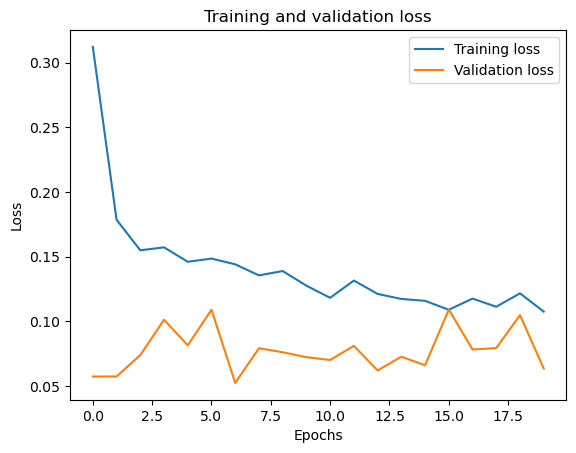

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(0, epochs), history_model.history['loss'], label = 'Training loss')
plt.plot(range(0, epochs), history_model.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

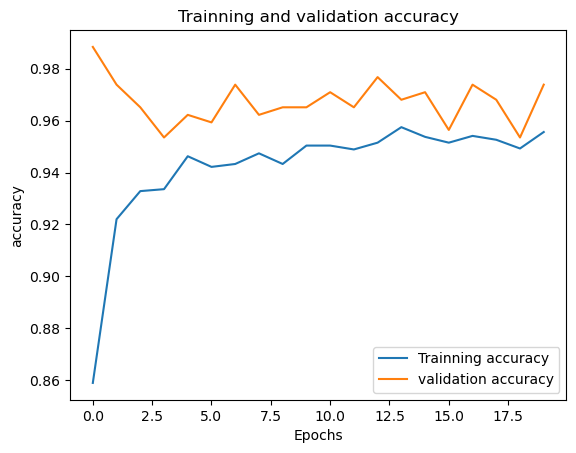

In [18]:
plt.plot(range(0, epochs), history_model.history['accuracy'], label = 'Trainning accuracy')
plt.plot(range(0, epochs), history_model.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Trainning and validation accuracy')
plt.legend()

## Predictions

In [19]:
y_pred = new_model.predict(X_val)
y_pred = y_pred.apply
y_pred

2024-08-13 17:48:26.988597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 84ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'apply'